## <center/> Digital Communication project 
<center/> Mahamat Hamid

In [1]:
from utils import *

In [2]:
# Parameters
L = 1000    # Number of bits divided by n which is number of bit/symbol associated with the modulation scheme
F = 8       # Oversampling factor
fe = 48e3   #  Sampling frequency 
# fs = fe/F   # payload Sampling frequency
Ω =  4      
β = 0.50001     # Roll-off factor
A = 1       # Signal amplitude
Δ = 1       # Filter energy normalization factor
SNR = 15    # Signal to noise ratio


## TRANSMISSION (QPSK) ##
# Generate random bits
m = np.random.randint(0, 2, (L,2))

# Mapping bits to symbols
d = bit2Symbol_Mapping_QPSK_Gray(A, m)

# Upsampling
dech = seqSymbEch(d,F)

# Raised cosine filtering of the signal (symbol sequence)
he = filterootcos(β,F,Ω)
s_he = np.convolve(he, dech)


The emission waveform filter $h_e$ is a Root-Raised Cosine (RRC) filter parameterized by $\beta \in (0,1]$ (Roll-off) and $T_s$ (Symbol Period) and defined as : 

$\bullet$ Time domain

$$ h_e (t) = \dfrac{4\beta}{\pi\sqrt{T_s}}\dfrac{\cos\left((1+\beta)\pi\frac{t}{T_s}\right)+\dfrac{\sin\left((1-\beta)\pi\frac{t}{T_s}\right)}{4\beta\frac{t}{T_s}}}{1-\left(4\beta\frac{t}{T_s}\right)^2} $$

$\bullet$ Frequency domain
$$ H_e(\nu) = \hat{h}_e(\nu) = \begin{cases}
\sqrt{T_s} & \text{if } |\nu| \in [0; \frac{1-\beta}{2T_s}] \\
\sqrt{\frac{T_s}{2}}\sqrt{1+\cos\left(\frac{\pi T_s}{\beta}\left(|\nu| - \frac{1-\beta}{2 T_s} \right) \right)} & \text{if } |\nu| \in [\frac{1-\beta}{2T_s}; \frac{1+\beta}{2T_s}] \\
0 & \text{otherwise}
\end{cases} $$


### Power spectral density (PSD) of the sampled signal $s_s (t)$ 

Occupied band:  9.00006 kHz


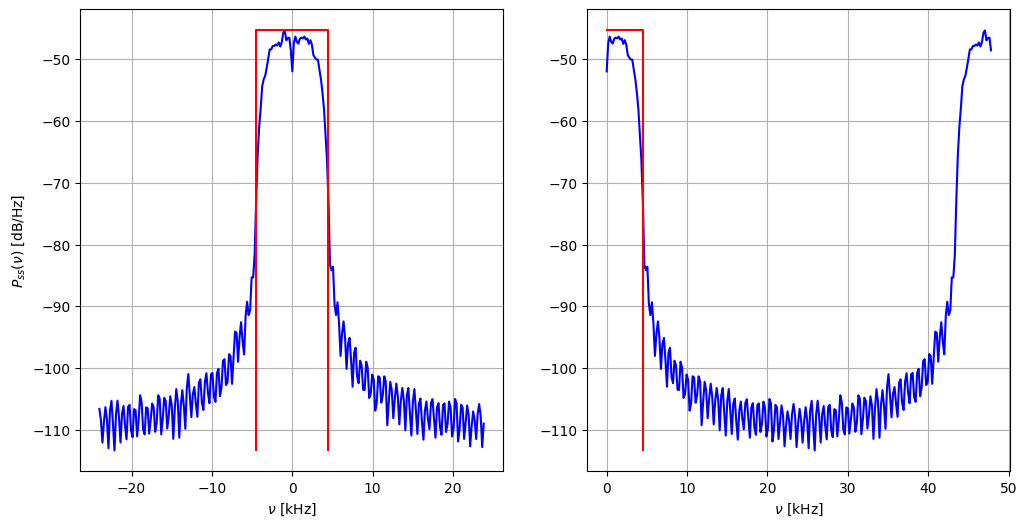

In [3]:
freq_u = 1e3 # freq unit in kHz

# Power spectral density of the emitted signal
freqs, val = sg.welch(s_he, fs=fe, return_onesided=False, scaling='density')

# Occupied band
B_occ = (1 + β) * fe/ F
print('Occupied band: ', B_occ / freq_u, 'kHz')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
idx_sort = np.argsort(freqs)
plt.plot(freqs[idx_sort] / freq_u, 10 * np.log10(val[idx_sort]), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.ylabel(r'$P_{ss}(\nu)$ [dB/Hz]')
max_psd = 10 * np.log10(np.max(val))
min_psd = 10 * np.log10(np.min(val))
x_f = (B_occ/2) / freq_u
plt.plot([-x_f, -x_f, x_f,x_f], [min_psd, max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()

plt.subplot(1,2,2)
freqs[freqs < 0] = freqs[freqs < 0] + fe # Shift to have the negative frequencies at the end
plt.plot(freqs / freq_u, 10 * np.log10(val), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.plot([0, x_f,x_f], [ max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()


Since the signal $s_s(t)$ is an a $f_e$-sampled signal, its spectral representation (or PSD) has an $f_e$-periodization
$$B_\text{occ} = D_s \times (1 + \beta) \quad[\text{Hz}] $$
is the filter's occupied bandwidth where $D_s$ is the symbol rate

In [4]:
## RECEPTION ##
s_hr = np.convolve(s_he, he)

### <center/> Eye diagram at the reception

Text(0, 0.5, 'Imaginary part')

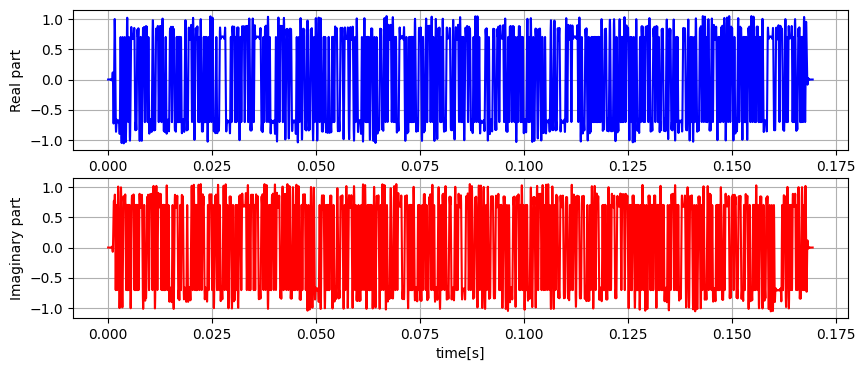

In [5]:
# plot real and imaginary part of the complex IQ signal
plt.figure(figsize=(10,4))

tt = np.arange(0, len(s_hr)) * 1/fe
plt.subplot(2,1,1)
plt.plot(tt, np.real(s_hr), 'b')
plt.grid()
plt.ylabel('Real part')

plt.subplot(2,1,2)
plt.plot(tt, np.imag(s_hr), 'r')
plt.grid()
plt.xlabel('time[s]')
plt.ylabel('Imaginary part')

There is a natural delay introduced by the filters on the signal

Text(0.5, 1.0, 'Eye diagram at the receiver side with \nroot raised cosine filter with roll-off factor $\\beta$ = 0.50001\nand oversampling factor F = 8')

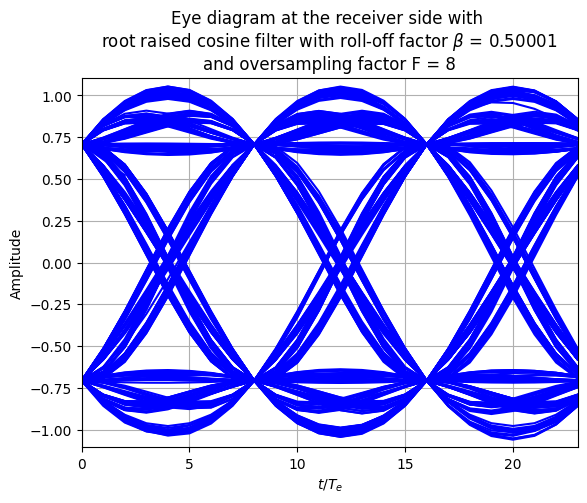

In [6]:
eye_diagram(s_hr, F, len(he), window_limit = 3)
plt.title("Eye diagram at the receiver side with \n"+fr"root raised cosine filter with roll-off factor $\beta$ = {β}"+ "\n"+fr"and oversampling factor F = {F}")

### <center/> Synchronization

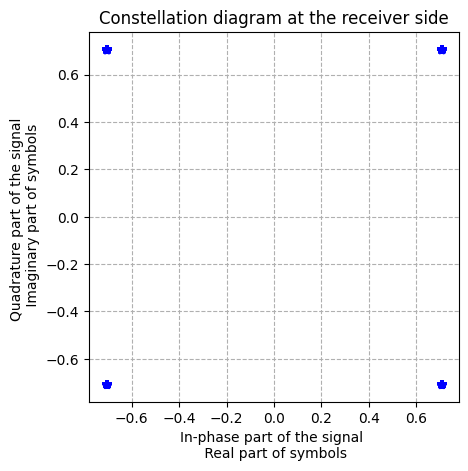

In [7]:
# selection of the samples
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*b')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
plt.title("Constellation diagram at the receiver side")
plt.grid(linestyle='--')  

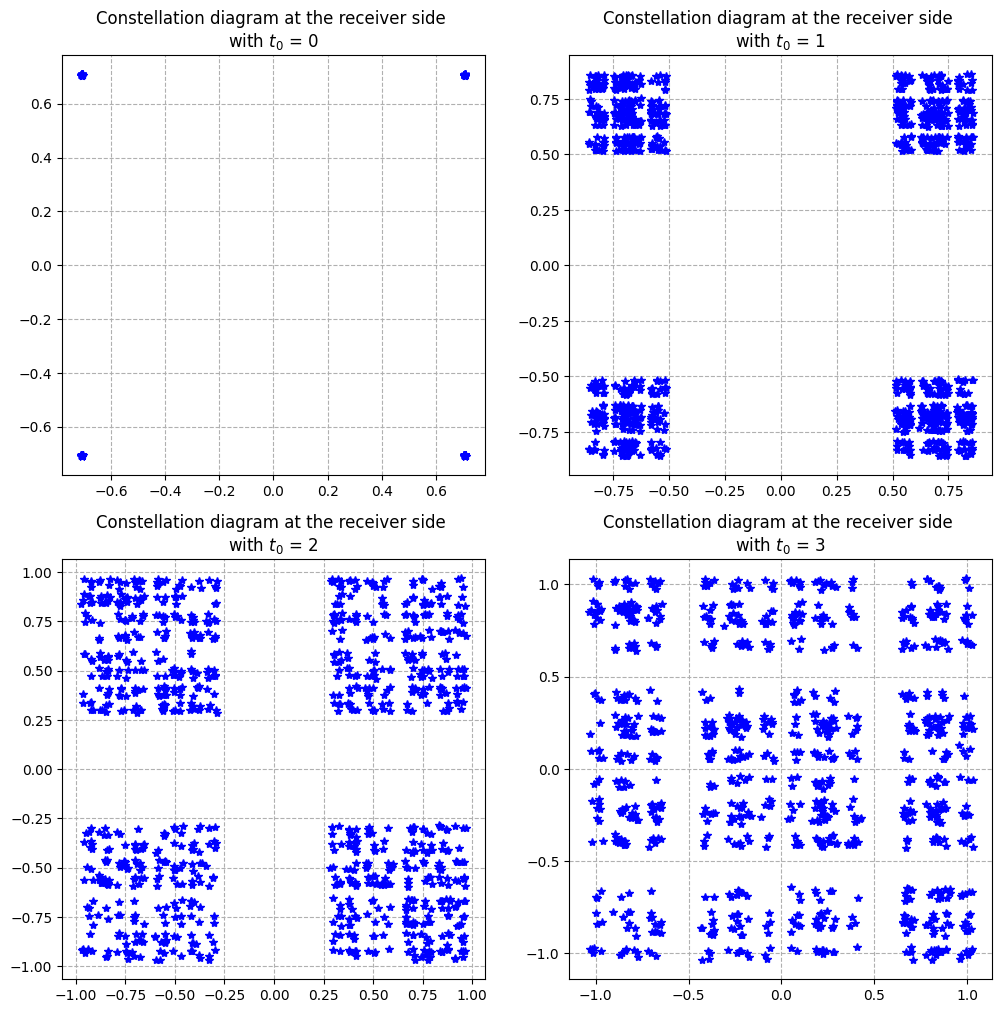

In [8]:
# subplots for 4 different idx_start
plt.figure(figsize=(12,12))
for idx_start in range(4):
    s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)
    plt.subplot(2,2,idx_start+1)
    plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*b')
    #plt.xlabel("In-phase part of the signal \n Real part of symbols")
    #plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
    plt.title("Constellation diagram at the receiver side \n" fr"with $t_0$ = "+str(idx_start))
    plt.grid(linestyle='--')



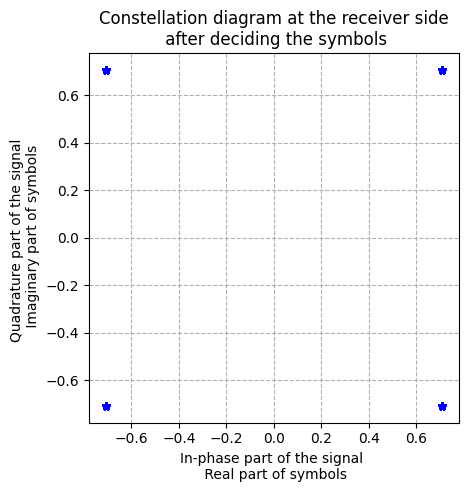

In [9]:
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)

# Demapping symbols to bits
d_est = MLSymbolDetectorQPSKlowCPLX(A,Δ,s_hr_ech)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.real(d_est), np.imag(d_est) ,'*b')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
plt.title("Constellation diagram at the receiver side\n after deciding the symbols")
plt.grid(linestyle='--')  

In [10]:
m_demapped = symbol2Bit_Demapping_QPSK_Gray(d_est)

In [11]:
(m_demapped == m).all()

np.True_

### <center/> Noisy AWGN channel

Text(0, 0.5, 'Quadrature part of the signal \n Imaginary part of symbols')

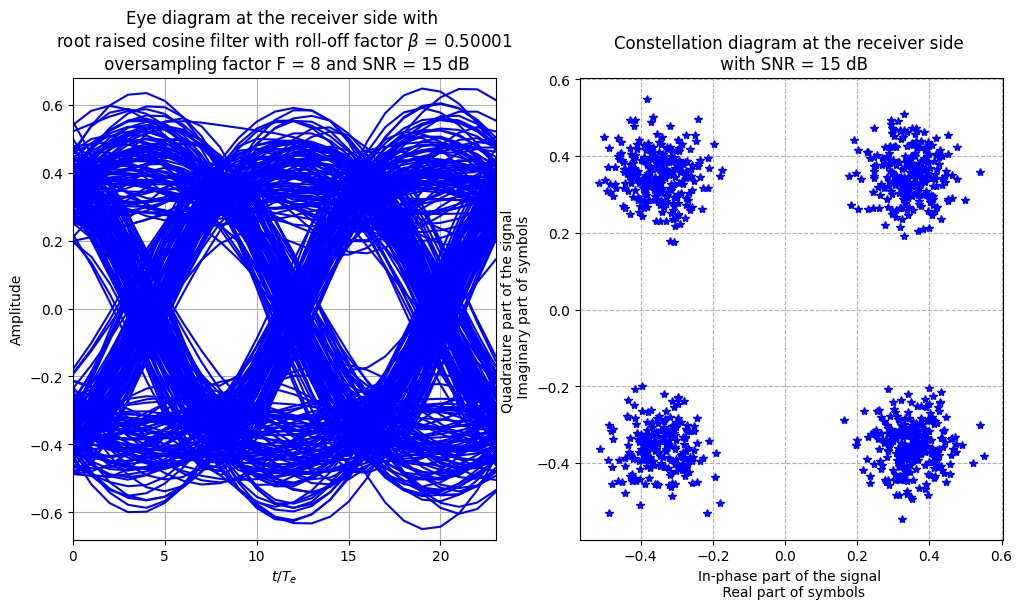

In [13]:
var = (A*Δ/2)**2 * 10 ** (-SNR/10)
z = AWGN(Δ, var, s_he)
s_hr = np.convolve(z, he)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
eye_diagram(s_hr, F, len(he), window_limit = 3)
plt.title("Eye diagram at the receiver side with \n"
+fr"root raised cosine filter with roll-off factor $\beta$ = {β}"+ "\n"
+fr" oversampling factor F = {F} and SNR = {SNR} dB")

plt.subplot(1,2,2)
idx_start = 0
s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*b')
plt.title("Constellation diagram at the receiver side \n with SNR = "+str(SNR)+" dB")
plt.grid(linestyle='--')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")

### <center/> SNR vs BER simulation curve

In [14]:
nb_frames = 100

# Parameters
L = 2000    # Number of bits divided by n which is number of bit/symbol associated with the modulation scheme
F = 8       # Oversampling factor
fe = 48e3   # Sampling frequency
Ω =  3      
β = 0.3     # Roll-off factor
A = 1       # Signal amplitude
Δ = 1       # Filter energy normalization factor
SNR = 15    # Signal to noise ratio

he = filterootcos(β,F,Ω)

SNR_list = np.arange(-2, 13)
SER = []
BER = []
idx_start = 0


for snr in SNR_list :
    ser_snr = []
    ber_snr = []

    for k in range(nb_frames) :
        
        m = np.random.randint(0, 2, (L,2))
        d = bit2Symbol_Mapping_QPSK_Gray(A, m)
        dech = seqSymbEch(d,F)
        s_he = np.convolve(he, dech)

        var = (A*Δ/2)**2 * 10 ** (-snr/10)
        z = AWGN(Δ, var, s_he)
        s_hr = np.convolve(z, he)

        s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)
        d_est = MLSymbolDetectorQPSKlowCPLX(A,Δ,s_hr_ech)
        m_demapped = symbol2Bit_Demapping_QPSK_Gray(d_est)

        ser_snr.append(np.sum(np.abs(d_est - d) != 0)/L)
        ber_snr.append(np.sum(np.abs(m_demapped - m) != 0)/(2*L))
    
    SER.append(np.mean(ser_snr))
    BER.append(np.mean(ber_snr))


In [15]:
# theoretical SER and BER
SER_th = erfc((0.5*10**(SNR_list/10))**0.5)
BER_th = SER_th / 2

### <center/> Error probability
$$P_\text{es}^\text{M-PSK} = \text{erfc}\left(\left(\sin\dfrac{\pi}{M}\right)^2\dfrac{\bar{E}}{N_0}\right) $$

$$P_\text{eb}^\text{M-PSK} = \frac{1}{\log_2(M)}\text{erfc}\left(\left(\sin\dfrac{\pi}{M}\right)^2\dfrac{\bar{E}}{N_0}\right) $$

Text(0.5, 1.0, 'SER and BER as a function of SNR')

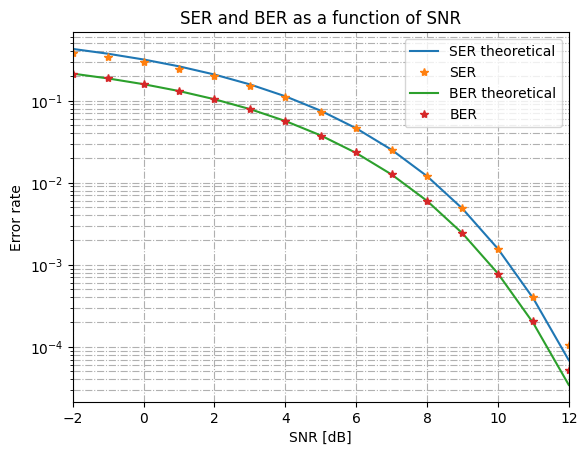

In [16]:
plt.semilogy(SNR_list, SER_th, label='SER theoretical')
plt.semilogy(SNR_list, SER, '*', label='SER')
plt.semilogy(SNR_list, BER_th, label='BER theoretical')
plt.semilogy(SNR_list, BER, '*', label='BER')
plt.xlabel('SNR [dB]')
plt.ylabel('Error rate')   
plt.grid(linestyle='-.', which='both')
plt.xlim(-2, 12)
plt.legend()
plt.title('SER and BER as a function of SNR')

In [27]:
## Emission ##
seed=17021999
np.random.seed(seed)
Lp = 256
m_preamble = np.random.randint(0, 2, (Lp,2))
d_ech_preamble = seqSymbEch(bit2Symbol_Mapping_QPSK_Gray(A, m_preamble), F)

L = 10_000
m_payload = np.random.randint(0, 2, (L,2))
m = np.vstack((m_preamble, m_payload))
d = bit2Symbol_Mapping_QPSK_Gray(A, m) 
dech = seqSymbEch(d,F)

## Channel ##
channel_delay = 100
d_delayed = np.concatenate((np.zeros(channel_delay), d))
dech_delayed = seqSymbEch(d_delayed,F)

s_he = np.convolve(he, dech_delayed)

z = AWGN(Δ, var, s_he)

## Reception ##
s_hr = np.convolve(z, he)

In [28]:
np.random.seed(seed)
corr = np.correlate(s_he, seqSymbEch(bit2Symbol_Mapping_QPSK_Gray(A,np.random.randint(0, 2, (Lp,2))), F))

In [29]:
tau_est = np.argmax(np.abs(corr))

In [30]:
tau_est

np.int64(824)

In [36]:
s_hr_ech = sychronization(s_hr, tau_est, F, len(he), d)

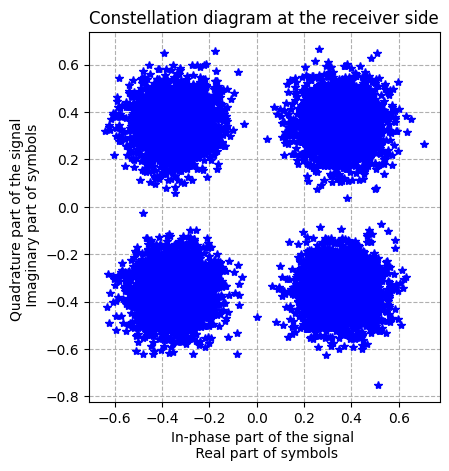

In [37]:
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.real(s_hr_ech), np.imag(s_hr_ech) ,'*b')
plt.xlabel("In-phase part of the signal \n Real part of symbols")
plt.ylabel("Quadrature part of the signal \n Imaginary part of symbols")
plt.title("Constellation diagram at the receiver side")
plt.grid(linestyle='--')  

In [ ]:
nb_frames = 100

# Parameters
L = 2000    # Number of bits divided by n which is number of bit/symbol associated with the modulation scheme
Lp = 256
F = 8       # Oversampling factor
fe = 48e3   # Sampling frequency
Ω =  3      
β = 0.3     # Roll-off factor
A = 1       # Signal amplitude
Δ = 1       # Filter energy normalization factor
SNR = 15    # Signal to noise ratio

he = filterootcos(β,F,Ω)

SNR_list = np.arange(-2, 13)
SER = []
BER = []
idx_start = 0


for snr in SNR_list :
    ser_snr = []
    ber_snr = []

    for k in range(nb_frames) :
        
        m = np.random.randint(0, 2, (L,2))
        d = bit2Symbol_Mapping_QPSK_Gray(A, m)
        dech = seqSymbEch(d,F)
        s_he = np.convolve(he, dech)

        var = (A*Δ/2)**2 * 10 ** (-snr/10)
        z = AWGN(Δ, var, s_he)
        s_hr = np.convolve(z, he)

        s_hr_ech = sychronization(s_hr, idx_start, F, len(he), d)
        d_est = MLSymbolDetectorQPSKlowCPLX(A,Δ,s_hr_ech)
        m_demapped = symbol2Bit_Demapping_QPSK_Gray(d_est)

        ser_snr.append(np.sum(np.abs(d_est - d) != 0)/L)
        ber_snr.append(np.sum(np.abs(m_demapped - m) != 0)/(2*L))
    
    SER.append(np.mean(ser_snr))
    BER.append(np.mean(ber_snr))
